# TP2 - Text-mining and chatbots
# Analysis of the QUAERO French Med Corpus
**Students**:
- Thanh Gia Hieu KHUONG
- Ragi BHATT
- Benedictus Kent RACHMAT

## QUAERO French Med corpus

The corpus is a resource for French medical language processing, comprising two versions (**BRAT**/**CoNLL**) and two subsets (**EMEA**/**MEDLINE**), each split into training, development, and test sets.

Let's start with defining the data path:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
from collections import Counter, defaultdict

# Define the path to the QUAERO FrenchMed TP2021
PATH="QUAERO_FrenchMed_TP2021"

## Objective

For each version, subset, and split of the corpus, analyze:

**1.** Number of tokens

**2.** Total number of entities

**3.** Number of unique entities

**4.** Number of entity types

**5.** Number of entities per type

## Parse BRAT Annotations

The function `parse_brat_annotation` is implemented to process these files. It reads each line of the annotation data, extracts entities, and categorizes them by their types. 

#### Steps:
1. **File Reading**: Each `.ann` (annotation) and corresponding `.txt` (text) file in the subsets are read.
2. **Token Counting**: Tokens in the text files are counted using regular expressions.
3. **Entity Analysis**: The parsed annotation data provides counts for the total number of entities, the number of unique entities, and the number of entities per type.

The `analyze_corpus` function iterates over each subset (EMEA and MEDLINE) and split (train, dev, test) in the corpus. For each subset and split, it processes the corresponding annotation and text files to gather the required statistics.

### Libraries Used

We didn't use any library specifically for this. We analyze them with normal Python libraries:

- `os`: For file path manipulations and directory traversals.
- `re`: Regular expressions for tokenization.
- `collections.Counter`: Efficient counting of entities per type.

In [10]:
def parse_brat_annotation(ann_data):
    entities = {}
    entity_types = set()
    unique_entities = set()

    for line in ann_data:
        if line.startswith('T'):
            parts = line.split('\t')
            entity_id = parts[0]
            entity_info = parts[1]
            entity_text = parts[2].strip()

            entity_type = entity_info.split(' ')[0]
            entities[entity_id] = {'type': entity_type, 'text': entity_text}

            unique_entities.add(entity_text)
            entity_types.add(entity_type)

    return entities, entity_types, unique_entities

def analyze_corpus(path):
    results = {}
    for subset in ['EMEA', 'MEDLINE']:
        for split in ['train', 'dev', 'test']:
            subset_path = os.path.join(path, split, subset)

            # Assuming the structure inside the subsets is similar to the provided 'train/EMEA' structure
            ann_files = [f for f in os.listdir(subset_path) if f.endswith('.ann')]
            txt_files = [f.replace('.ann', '.txt') for f in ann_files]

            # Initialize counters for the subset
            subset_data = {
                'number_of_tokens': 0,
                'total_number_of_entities': 0,
                'number_of_unique_entities': 0,
                'number_of_entity_types': 0,
                'number_of_entities_per_type': Counter()
            }

            for ann_file, txt_file in zip(ann_files, txt_files):
                with open(os.path.join(subset_path, txt_file), 'r') as f:
                    txt_data = f.read()

                with open(os.path.join(subset_path, ann_file), 'r') as f:
                    ann_data = f.readlines()

                # Parse the BRAT annotations
                entities, entity_types, unique_entities = parse_brat_annotation(ann_data)
                
                # Count the total number of tokens in the text file
                tokens = re.findall(r'\b\w+\b', txt_data)
                subset_data['number_of_tokens'] += len(tokens)

                # Update entity counts for the subset
                subset_data['total_number_of_entities'] += len(entities)
                subset_data['number_of_unique_entities'] += len(unique_entities)
                # subset_data['number_of_entity_types'] = len(entity_types)  # entity types vary across files

                # Update the number of entities per type
                subset_data['number_of_entities_per_type'].update([entity['type'] for entity in entities.values()])
                
            # Update the number of entity types
            subset_data['number_of_entity_types'] = len(subset_data['number_of_entities_per_type'])


            # Convert Counter to dict
            subset_data['number_of_entities_per_type'] = dict(subset_data['number_of_entities_per_type'])
            
            # Save the results for the subset
            results[subset + '_' + split] = subset_data

    return results

# Analyze the corpus and get the results
brat_results = analyze_corpus(os.path.join(PATH, "QUAERO_FrenchMed_BRAT/corpus"))
brat_results


{'EMEA_train': {'number_of_tokens': 12806,
  'total_number_of_entities': 2695,
  'number_of_unique_entities': 1337,
  'number_of_entity_types': 10,
  'number_of_entities_per_type': {'GEOG': 22,
   'DEVI': 48,
   'OBJC': 71,
   'CHEM': 727,
   'PROC': 433,
   'DISO': 736,
   'PHYS': 119,
   'LIVB': 273,
   'ANAT': 247,
   'PHEN': 19}},
 'EMEA_dev': {'number_of_tokens': 11434,
  'total_number_of_entities': 2260,
  'number_of_unique_entities': 1208,
  'number_of_entity_types': 10,
  'number_of_entities_per_type': {'OBJC': 50,
   'CHEM': 870,
   'PHEN': 10,
   'PROC': 250,
   'PHYS': 140,
   'DISO': 458,
   'LIVB': 276,
   'GEOG': 29,
   'DEVI': 22,
   'ANAT': 155}},
 'EMEA_test': {'number_of_tokens': 10320,
  'total_number_of_entities': 2204,
  'number_of_unique_entities': 1156,
  'number_of_entity_types': 10,
  'number_of_entities_per_type': {'CHEM': 885,
   'DISO': 316,
   'ANAT': 181,
   'PROC': 269,
   'LIVB': 268,
   'PHYS': 85,
   'OBJC': 53,
   'PHEN': 33,
   'DEVI': 100,
   'GEOG'

We will plot the difference between 2 subset at the end of the notebook.

## Parse CoNLL Annotations

The function `get_statistics` is implemented to process these files. It reads each line of the annotation data, extracts entities, and categorizes them by their types. 

#### Steps:

**1.** File Reading: Each file within the subsets and splits is read using the pandas library.
   
**2.** Data Processing: The files are processed to count tokens, identify and categorize entities, and aggregate them by their types.
   
**3.** Entity Handling: **Multi-token entities** (e.g., 'CHEM-B', 'CHEM-I') **are merged into single entities** for accurate counting.

### Libraries Used

We didn't use any library specifically for this. We analyze them with normal Python libraries:

- `os`: For file path manipulations and directory traversals.
- `re`: Regular expressions for tokenization.
- `collections.defaultdict`: Efficient counting of entities per type.

In [11]:
def get_statistics(dataset_dir):
  statistics = {}
  for split in ['train', 'dev', 'test']:
    for subset in ['EMEA', 'MEDLINE']:
      split_dir = os.path.join(dataset_dir, split, subset)

      if not os.path.exists(split_dir):
        continue

      # Iterate over each file in the split directory
      for file in os.listdir(split_dir):
          file_path = os.path.join(split_dir, file)

          conll_df = pd.read_csv(file_path, sep='\t', header=None, names=['entity', 'start', 'end', 'token'])

          conll_df.dropna(inplace=True)
          conll_df.reset_index(drop=True, inplace=True)

          # Number of tokens
          number_of_tokens = conll_df.shape[0]

          # Number of entities
          entities = conll_df[conll_df['entity'] != 'O'][['entity', 'token']]
          # Merge multi-token entities (e.g. 'CHEM-B', 'CHEM-I') into a single entity
          def combine_rows(df):
              # Create a new DataFrame to store results
              combined_df = pd.DataFrame(columns=['entity', 'token'])

              current_entity = ''
              current_token = ''

              for _, row in df.iterrows():
                  entity = row['entity']
                  token = row['token']

                  if entity.endswith('-B'):
                      if current_entity:
                          # Save the previous entity
                          # combined_df = combined_df.append({'entity': current_entity[:-2], 'token': current_token}, ignore_index=True)
                            combined_df.loc[len(combined_df)] = [current_entity[:-2], current_token]
                      # Start a new entity
                      current_entity = entity
                      current_token = token
                  elif entity.endswith('-I') and current_entity:
                      # Continue the current entity
                      current_token += ' ' + token

              # Add the last entity if exists
              if current_entity:
                #   combined_df = combined_df.append({'entity': current_entity[:-2], 'token': current_token}, ignore_index=True)
                    combined_df.loc[len(combined_df)] = [current_entity[:-2], current_token]

              return combined_df
          entities = combine_rows(entities)
          
          num_entities = len(entities)
          num_entities_types = len(entities['entity'].unique())

          # Number of unique entities
          unique_entities = entities.drop_duplicates()
          number_of_unique_entities = len(unique_entities)

          # Number of entities per type
          entities_per_type = defaultdict(int)
          for entity in entities['entity']:
              entities_per_type[entity] += 1

          statistics[f"{subset}_{split}"] = {
              'number_of_tokens': number_of_tokens,
              'total_number_of_entities': num_entities,
              'number_of_unique_entities': number_of_unique_entities,
              'number_of_entity_types': num_entities_types,
              'number_of_entities_per_type': entities_per_type
          }
  return statistics 
    
conll_results = get_statistics("QUAERO_FrenchMed_TP2021/QUAERO_FrenchMed_conll/corpus")
conll_results

{'EMEA_train': {'number_of_tokens': 15339,
  'total_number_of_entities': 2336,
  'number_of_unique_entities': 822,
  'number_of_entity_types': 10,
  'number_of_entities_per_type': defaultdict(int,
              {'CHEM': 678,
               'PROC': 390,
               'DISO': 621,
               'LIVB': 256,
               'ANAT': 126,
               'DEVI': 48,
               'OBJC': 70,
               'PHEN': 19,
               'PHYS': 107,
               'GEOG': 21})},
 'MEDLINE_train': {'number_of_tokens': 11441,
  'total_number_of_entities': 2190,
  'number_of_unique_entities': 1838,
  'number_of_entity_types': 10,
  'number_of_entities_per_type': defaultdict(int,
              {'PROC': 496,
               'DISO': 705,
               'CHEM': 266,
               'ANAT': 238,
               'LIVB': 241,
               'PHYS': 119,
               'PHEN': 41,
               'OBJC': 23,
               'DEVI': 29,
               'GEOG': 32})},
 'EMEA_dev': {'number_of_tokens': 13543,
  '

## Plot the analysis side-by-side

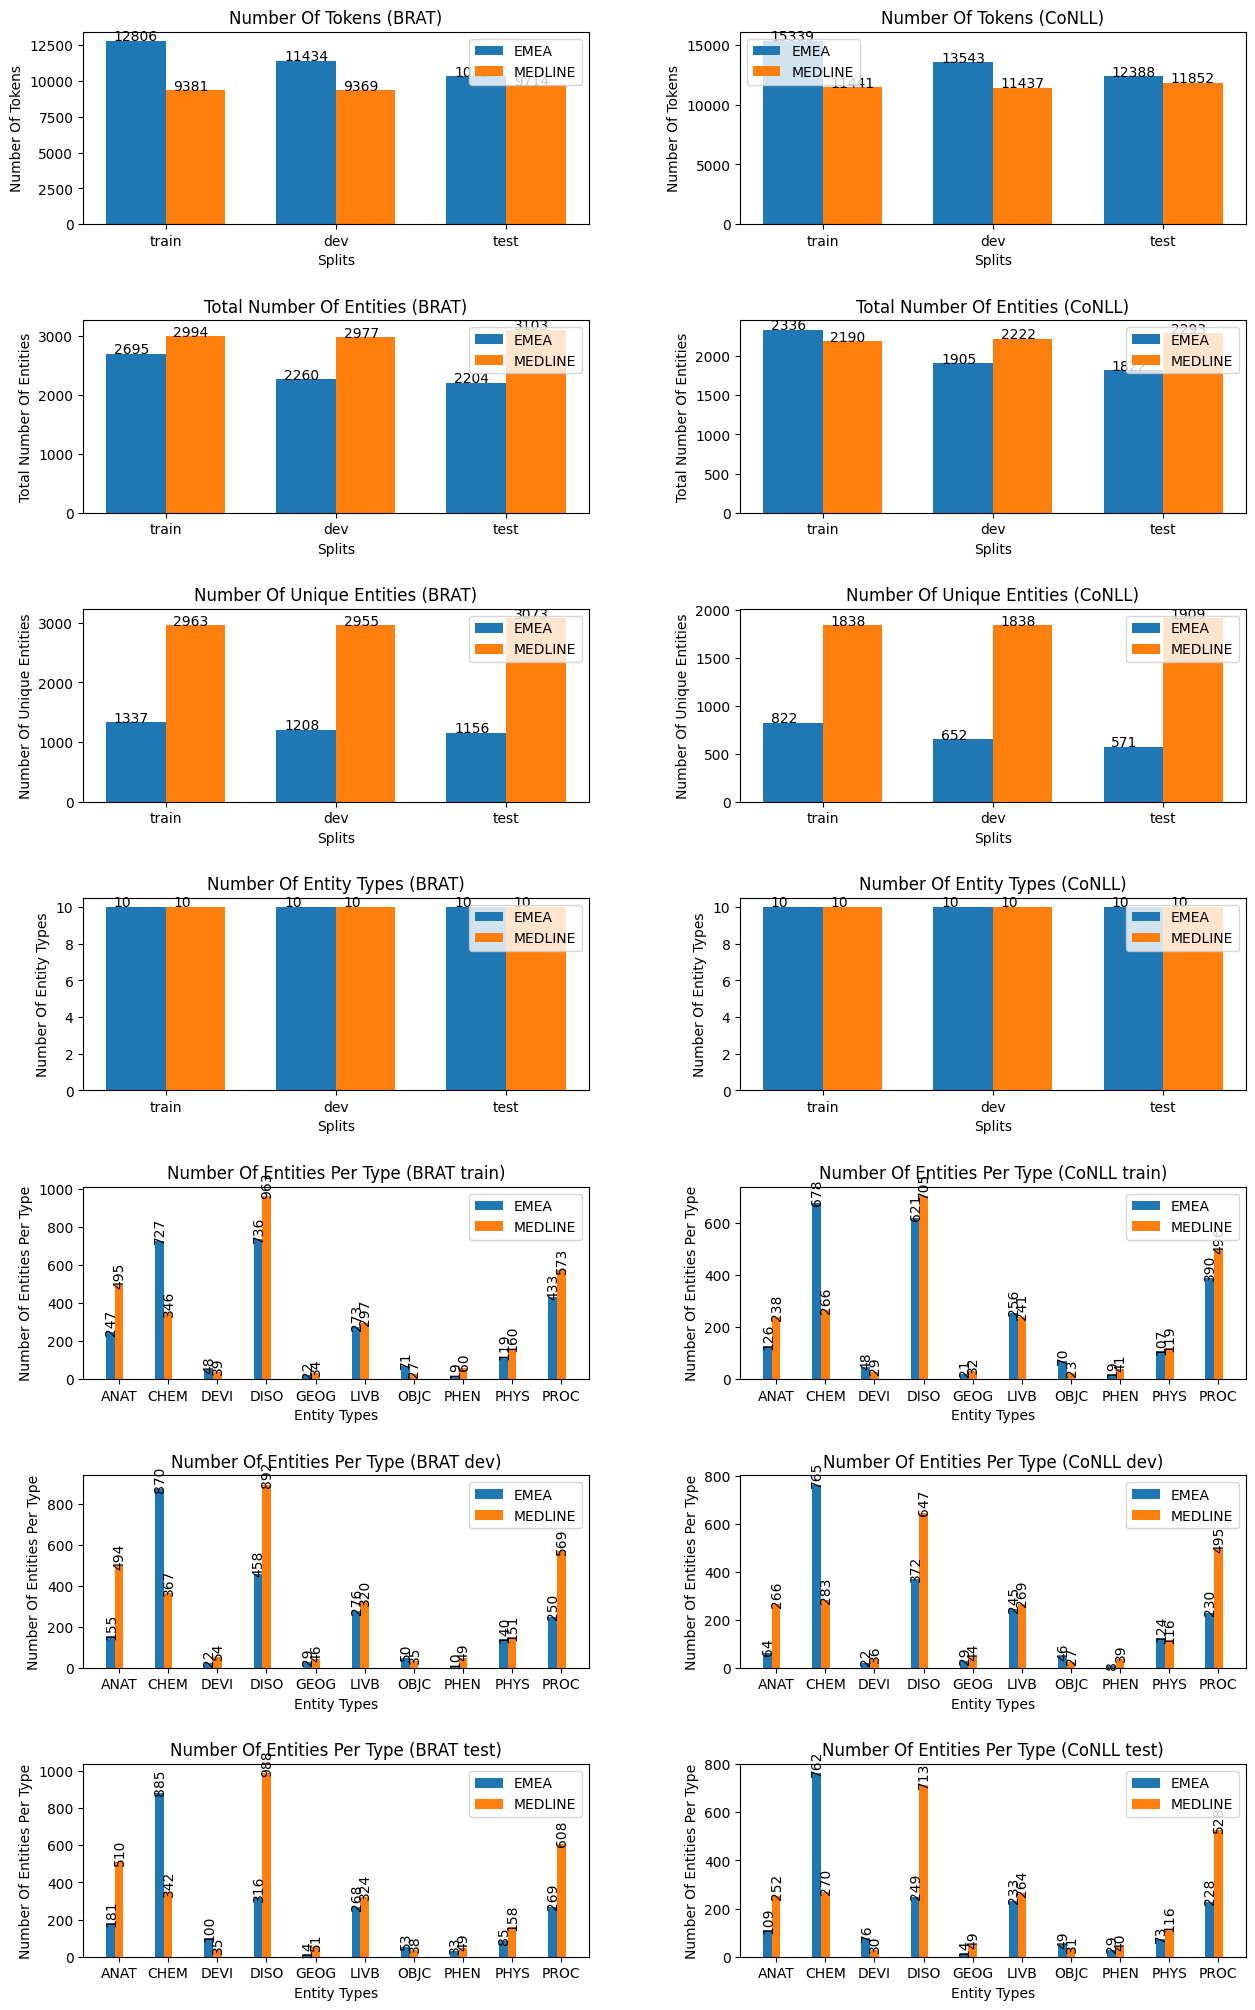

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_statistics(brat_stats, conll_stats):
    # Define subsets and splits
    subsets = ['EMEA', 'MEDLINE']
    splits = ['train', 'dev', 'test']
    categories = ['number_of_tokens', 'total_number_of_entities', 'number_of_unique_entities', 'number_of_entity_types', 'number_of_entities_per_type']
    
    # Create a 7x2 subplot for each category and each format (BRAT and CoNLL)
    fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 25))
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    
    for i, category in enumerate(categories):
        for j, data_format in enumerate([brat_stats, conll_stats]):
            ax = axes[i][j]
            
            # Prepare the data for plotting
            data = {
                subset: [data_format[f"{subset}_{split}"].get(category, 0) if isinstance(data_format[f"{subset}_{split}"], dict) else 0
                         for split in splits]
                for subset in subsets
            }
            
            n_groups = len(splits)
            index = np.arange(n_groups)
            bar_width = 0.35
            
            # Create the bar plot
            for k, (subset, counts) in enumerate(data.items()):
                if category == 'number_of_entities_per_type':
                    for spl, entity_count_per_type in enumerate(counts):
                        ax = axes[i+spl][j]
                        
                        # Reorder the entities by their key names
                        entity_count_per_type = {k: v for k, v in sorted(entity_count_per_type.items(), key=lambda item: item[0])}
                        ax.bar(np.arange(len(entity_count_per_type)) + k * bar_width / len(subsets), entity_count_per_type.values(),
                            bar_width / len(subsets), label=subset)
                        # Add labels for each bar
                        for idx, value in enumerate(entity_count_per_type.values()):
                            ax.text(idx + k * bar_width / len(subsets) - 0.13, value + 0.15, str(value), rotation=90)
                        
                    
                        # Add labels, title, and legend
                        ax.set_xlabel('Entity Types')
                        ax.set_ylabel(category.replace('_', ' ').title())
                        ax.set_title(f'{category.replace("_", " ").title()} ({["BRAT", "CoNLL"][j]} {["train", "dev", "test"][spl]})')
                        ax.set_xticks(np.arange(len(entity_count_per_type)) + bar_width / 2)
                        ax.set_xticklabels(entity_count_per_type.keys())
                        ax.legend()
                    
                else:
                    ax.bar(index + k * bar_width, counts, bar_width, label=subset)
                    # Add labels for each bar
                    for idx, value in enumerate(counts):
                        ax.text(idx + k * bar_width - 0.13, value + 0.05, str(value))

                    # Add labels, title, and legend
                    ax.set_xlabel('Splits')
                    ax.set_ylabel(category.replace('_', ' ').title())
                    ax.set_title(f'{category.replace("_", " ").title()} ({["BRAT", "CoNLL"][j]})')
                    ax.set_xticks(index + bar_width / 2)
                    ax.set_xticklabels(splits)
            ax.legend()

    # Show the plot
    plt.show()
plot_statistics(brat_results, conll_results)

### Final Discussion is in our report